For detailed explaination, refer to:
1. Shivpuje, Saurabh, Manas Sajjan, Yuchen Wang, Zixuan Hu, and Sabre Kais. "Designing variational ansatz for quantum-enabled simulation of non-unitary dynamical evolution-an excursion into Dicke supperradiance." arXiv preprint arXiv:2403.04653 (2024).
2. Chen, Huo, Niladri Gomes, Siyuan Niu, and Wibe Albert de Jong. "Adaptive variational simulation for open quantum systems." arXiv preprint arXiv:2305.06915 (2023).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import combinations, product
from scipy.linalg import expm, kron
from numpy.random import rand
from qutip import mesolve, Qobj

FMO Complex dynamics values

In [2]:
H = [
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
]
H_fmo= np.pad(H, ((0, 3), (0, 3)), mode='constant')

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(L_temp)
Llist_f_padded = [np.pad(matrix, ((0, 3), (0, 3)), mode='constant') for matrix in Llist_f]

#initial state
u0_fmo = np.zeros(8,dtype=np.complex_)
u0_fmo[1] = 1

In [3]:
def tag(A):
    return getattr(A, 'tag', None) if A is not None else None


def aexp(A, theta):
    return expm(-1j * theta * A.mat / 2)

def add_A(A, P):
    A.A.append(P)
    A.theta = np.append(A.theta, 0)

def lmul(A, ψ):
    # print("ehrerw:",A)
    # print("amat:",np.shape(A.mat))
    # print("her in lmul",A.mat @ ψ)
    return A.mat @ ψ

def update_theta(ansatz, dtheta, dt):
    ansatz.theta = ansatz.theta + dtheta * dt

def partial_theta(A):
    len_A = len(A.A)
    ψ = A.ref.copy()
    res = []
    for i in range(len_A):
        ψ = aexp(A.A[i], A.theta[i]) @ ψ
        ψt = -0.5j * lmul(A.A[i], ψ)
        for j in range(i + 1, len_A):
            ψt = aexp(A.A[j], A.theta[j]) @ ψt
        res.append(ψt)
    return res

def build_m(ψ, dψ):
    l = len(dψ)
    res = np.zeros((l, l))
    ψ = ψ[:, np.newaxis] if len(ψ.shape) == 1 else ψ

    for μ in range(l):
        for ν in range(l):
            res[μ, ν] = 2 * np.real(dψ[μ].T.conj() @ dψ[ν] + ψ.T.conj() @ dψ[μ] @ ψ.T.conj() @ dψ[ν])
    return res

def update_m(m, dψa, ψ, dψ):
    l = m.shape[0]
    mp = np.zeros((l + 1, l + 1))
    dψa = dψa[:, np.newaxis]
    ψ = ψ[:, np.newaxis]
    mp[l, l] = 2 * np.real((dψa.T.conj() @ dψa + ψ.T.conj() @ dψa @ ψ.T.conj() @ dψa).item())
    mp[:l, :l] = m
    for μ in range(l):
        temp = 2 * np.real(dψ[μ].T.conj() @ dψa + ψ.T.conj() @ dψ[μ] @ ψ.T.conj() @ dψa)
        mp[μ, l] = temp.item()
        mp[l, μ] = temp.item()
    return mp

def build_v(ψ, dψ, He, Ha):
    L = -1j * (He - 1j * Ha)
    l = len(dψ)
    ψ = ψ[:, np.newaxis] if len(ψ.shape) == 1 else ψ
    res = np.zeros(l)
    for μ in range(l):
        res[μ] = 2 * np.real((dψ[μ].T.conj() @ L @ ψ + dψ[μ].T.conj() @ ψ @ ψ.T.conj() @ L.T.conj() @ ψ).item())
    return res

def update_v(v, dψₐ, ψ, He, Ha):
    L = -1j * (He - 1j * Ha)
    l = len(v)
    dψₐ = dψₐ[:, np.newaxis]
    ψ = ψ[:, np.newaxis]
    vp = np.zeros(l + 1)
    vp[:l] = v
    vp[l] = 2 * np.real((dψₐ.T.conj() @ L @ ψ + dψₐ.T.conj() @ ψ @ ψ.T.conj() @ L.T.conj() @ ψ).item())
    return vp

def lin_solve(m, v, λ=1e-4):
    A = m.T @ m
    try:
        xλ = np.linalg.solve(A + λ**2 * np.eye(A.shape[0]), m.T @ v)
    except np.linalg.LinAlgError:
        xλ = np.linalg.lstsq(A + λ**2 * np.eye(A.shape[0]), m.T @ v, rcond=None)[0]
    return xλ, 2 * v.T @ xλ - xλ.T @ m @ xλ

def get_newest_A(A):
    return A.A[-1] if A.A else None

def update_state(A):
    if A.A:
        state = A.ref.copy()
        for i in range(len(A.A)):
            state = aexp(A.A[i], A.theta[i]) @ state
        A.state = state
    else:
        A.state = A.ref

def set_ref(A, ref):
    A.ref = ref

def reset(A):
    A.theta = np.array([])
    A.A = []
    update_state(A)

class Result:
    def __init__(self, t, psi, energy, pop, theta, A, jump_t, jump_L, status):
        self.t = t
        self.psi = psi
        self.energy = energy  # Add energy attribute
        self.pop = pop
        self.theta = theta
        self.A = A
        self.jump_t = jump_t
        self.jump_L = jump_L
        self.status = status

    def __repr__(self):
        return f"Result(t={self.t}, psi={self.psi}, energy={self.energy}, pop={self.pop}, theta={self.theta}, A={self.A}, jump_t={self.jump_t}, jump_L={self.jump_L}, status={self.status})"

class AVQDSol:
    def __init__(self, t, u, θ, A, jump_L, jump_t, status=0, norm=[]):
        self.t = t
        self.u = u
        self.θ = θ
        self.A = A
        self.jump_L = jump_L
        self.jump_t = jump_t
        self.status = status
        self.norm = norm

def one_step(A, He, Ha, dt):

    relrcut = A.relrcut
    psi_ = A.state
    dpsi_ = partial_theta(A)
    M = build_m(psi_, dpsi_)
    V = build_v(psi_, dpsi_, He, Ha)
    dtheta, vmv = lin_solve(M, V)
    vmvMax = vmv
    Mtmp = M
    Vtmp = V
    dthetatmp = dtheta
    opTmp = None
    dpsi_ₐTmp = None
    add_flag = True

    while add_flag:
        # print("here in onestep While")
        tagTmp = None
        # print("Ansatz pool:",A.pool)
        for op in A.pool:
            # print("opertaro from pool:",(op.tag))
            if tag(get_newest_A(A)) == tag(op):
                # print("here in get newest_A")
                continue
            # print("here in op for loop")
            dpsi_ₐ = -0.5j * lmul(op, psi_)

            Mop = update_m(M, dpsi_ₐ, psi_, dpsi_)
            # print("Mop:",Mop)
            Vop = update_v(V, dpsi_ₐ, psi_, He, Ha)
            dthetaop, vmvOp = lin_solve(Mop, Vop)
            # print("berfore the if:","vmvOp:",vmvOp, "vmvMax:",vmvMax)

            if vmvOp > vmvMax:
                # print("vmvOp:",vmvOp, "vmvMax:",vmvMax)

                Mtmp = Mop
                Vtmp = Vop
                vmvMax = vmvOp
                dthetatmp = dthetaop
                opTmp = op
                tagTmp = tag(op)
                # print("tagTmp:",tagTmp)
                dpsi_ₐTmp = dpsi_ₐ
        # print("vmvMax - vmv:",vmvMax-vmv)
        add_flag = vmvMax - vmv >= relrcut

        

        if tagTmp is not None and add_flag:

            add_A(A, opTmp)
            vmv = vmvMax
            M = Mtmp
            V = Vtmp
            dtheta = dthetatmp
            dpsi_.append(dpsi_ₐTmp)

    update_theta(A, dtheta, dt)
    # print("Ansatz:",A.theta)
    update_state(A)



### System evolution


### Solver function

In [4]:
def solve_avq_traj(H, A, tspan, dt, save_state=True, save_everystep=True):
    # Store initial reference state for reinitialization
    ref_init = A.ref.copy()
    update_state(A)
    
    # Initialize time and recorder lists
    t = tspan[0]
    t_list = []
    u_list = []
    theta_list = []
    A_list = []
    jump_L_list = []
    jump_t_list = []

    # Break flag for error handling
    break_flag = False
    Gamma = 0  # Jump recorder
    q = rand()  # Random number for quantum jump
    # print("expo:",np.exp(-Gamma))
    # print("random q:", q)

    if save_everystep:
        t_list.append(t)
        theta_list.append(A.theta.copy())

        A_list.append([tag(a) for a in A.A])
        if save_state:
            u_list.append(A.state.copy())

    # Main evolution loop
    # This loop performs the simulation of quantum system evolution over a set time span.
    # It integrates the system state forward in time while handling both deterministic 
    # evolution and stochastic quantum jumps.

    while t + dt <= tspan[1]:  # Loop over the total time span with step size dt
        # print("timestep:", dt)  # Print current time step size for monitoring
        He = H.He  # Extract Hermitian Hamiltonian component for deterministic evolution
        Ha = H.Ha  # Extract Antihermitian Hamiltonian component for jump handling

        if np.exp(-Gamma) > q:  # Check if no quantum jump occurs, based on jump probability threshold
            try:
                one_step(A, He, Ha, dt)  # Perform deterministic evolution for one time step
            except Exception:  # In case of failure, exit the loop with a flag
                break_flag = True
                break
            psi_ = A.state  # Update the current state of the system
            Gamma += 2 * np.real(psi_.T.conj() @ Ha @ psi_) * dt  # Update accumulated Gamma for jump probability

            if save_everystep:  # Option to save state at every time step
                t_list.append(t + dt)  # Save current time
                theta_list.append(A.theta.copy())  # Save current ansatz parameters
                A_list.append([tag(a) for a in A.A])  # Save current state of ansatz components

        else:  # Quantum jump occurs
            psi_ = A.state  # Get current state before jump

            # Compute the probabilities for different jump operators
            weights = np.array([np.real(psi_.T.conj() @ LdL @ psi_) for LdL in H.LdL])

            # Randomly choose a jump operator based on computed probabilities
            L_index = np.random.choice([i for i in range(np.shape(H.Llist)[0])], p=weights/weights.sum())
            L = H.Llist[L_index]  # Select corresponding jump operator

            # Apply the jump operator to the state and normalize it
            psi_n = L @ psi_ / np.linalg.norm(L @ psi_)

            # Record the jump event details (time and operator used)
            jump_t_list.append(t)
            jump_L_list.append(tag(L))

            # Record the state and parameters post-jump
            t_list.append(t + dt)
            set_ref(A, psi_n)  # Update the state with post-jump state
            reset(A)  # Reset the ansatz parameters after jump

            # Save updated ansatz parameters post-jump
            theta_list.append(A.theta.copy())
            A_list.append([tag(a) for a in A.A])

            # Reset the jump probability accumulator
            Gamma = 0
            q = rand()  # Generate a new random number for the next jump check

        # Optionally save the state at each time step
        if save_state:
            u_list.append(A.state.copy())  # Store the current state

        # Increment the simulation time by dt
        t += dt


    # Final check for status if no errors occurred
    if not break_flag:
        if (not jump_t_list or not np.isclose(t, jump_t_list[-1])) and not save_everystep:
            theta_list.append(A.theta.copy())
            A_list.append([tag(a) for a in A.A])

    # Reset the ansatz to the initial condition
    # print("ansatz before reset:",A.A)
    set_ref(A, ref_init)
    reset(A)
    # print("tlist:",t_list)
    # Return solution object
    return AVQDSol(t_list, u_list, theta_list, A_list, jump_L_list, jump_t_list, status=0 if not break_flag else 1)

In [5]:
def solve_avq_trajectory(H, ansatz, tf, dt):
    # Solve for a single trajectory using solve_avq
    res = solve_avq_traj(H, ansatz, [0, tf], dt, save_state=True, save_everystep=True)
    
    # Post-process the results to extract energy and populations
    tlist = res.t
    psi_list = res.u
    energy = []
    pop = []
    
    for i in range(len(tlist)):
        psi = psi_list[i]
        energy.append(np.real(np.conj(psi.T) @ (H.He) @ psi))  # Energy
        pop.append([np.abs(psi[0])**2, np.abs(psi[1])**2])  # Population in ground/excited states for amplitude damping

    return Result(tlist, psi_list, energy, pop, res.θ, res.A, res.jump_t, res.jump_L, res.status)
    pass

In [6]:
class EffectiveHamiltonian_class:
    def __init__(self, He, Ha, Llist, LdL):
        self.He = He  # Hermitian part
        self.Ha = Ha  # Anti-Hermitian part
        self.Llist = Llist  # List of Lindblad operators
        self.LdL = LdL  # List of L†L

def EffectiveHamiltonian( mats, Llist):
    """
    Create an EffectiveHamiltonian object based on provided parameters.
    :param mats: List of matrices (Hamiltonian terms).
    :param Llist: List of lists of Lindblad operators.
    :return: An instance of EffectiveHamiltonian_class.
    """
    # Directly use the input matrices as the Hermitian part (assuming they are Hermitian)
    He = sum(mats)  # Sum of Hamiltonian terms as Hermitian part
    Ha = 0.0  # Initialize anti-Hermitian part
    LdL = []  # Initialize the list for Lindblad operator products

    for  LL in Llist:
        for L in LL:
            L_dagger_L = (L.conj().T @ L) 
            
            LdL.append(L_dagger_L)  # Append to LdL list
            Ha += L_dagger_L  # Sum for the anti-Hermitian part

    # Return the Effective Hamiltonian object
    return EffectiveHamiltonian_class(He, 0.5 * Ha, [L for LL in Llist for L in LL], LdL)

### Designing Ansatz

In [7]:
# Ansatz Class and Operators
class Ansatz_class:
    def __init__(self, nqbit, u0, relrcut, pool, theta=[], ansatz=[]):
        self.theta = np.array(theta)
        self.A = ansatz
        self.state = u0.copy()
        self.ref = u0.copy()
        self.relrcut = relrcut
        self.nqbit = nqbit
        self.pool = pool

class AnsatzOperatorBase:
    pass

class PauliOperator_class(AnsatzOperatorBase):
    def __init__(self, mat, tag, nqbit):
        self.mat = mat
        self.tag = tag
        self.nqbit = nqbit

def single_clause(ops, q_ind, weight, num_qubit):
    si = np.eye(2)
    res = weight * np.eye(1)
    for i in range(1, num_qubit + 1):
        if i in q_ind:
            op2 = eval(f"{ops[q_ind.index(i)]}")
            res = kron(res, op2)
        else:
            res = kron(res, si)
    return res

def PauliOperator(ops, idx, w, nqbit):
    sortedRep = sorted(zip(ops, idx), key=lambda x: x[1])
    tag = ''.join([f"{o}{i}" for o, i in sortedRep])
    mat = single_clause(ops, idx, w, nqbit)
    return PauliOperator_class(mat, tag, nqbit)

# Defining pool of operators/gates
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
# S = np.array([[1, 0], [0, 1j]])


def build_pool(nqbit):
    pauliStr = ["sx", "sz", "sy"]
    res = []
    for order in range(1, nqbit+1):
        for idx in combinations(range(1, nqbit + 1), order):
            for op in product(pauliStr, repeat=order):
                res.append(PauliOperator(op, list(idx), 1, nqbit))
    return res

def Ansatz(u0, relrcut, theta=[], ansatz=[]):
    nqbit = int(np.log2(len(u0)))
    pool_qubit =  nqbit
    # u0 = np.outer(u0, u0).flatten()
    pool = build_pool(pool_qubit)
    return Ansatz_class(nqbit, u0, relrcut, pool, theta, ansatz)

### Example execution

In [8]:
# def run_trajectories(num_trajectory, H, ansatz, tf, dt):
#     # Create a list of tuples with the required parameters for each trajectory
#     param_list = [(H, ansatz, tf, dt) for _ in range(num_trajectory)]
    
#     with Pool() as pool:
#         results = pool.starmap(solve_avq_trajectory, param_list)
    
#     return results
def run_trajectories(num_trajectory, H, ansatz, tf, dt):
    results = []
    for _ in range(num_trajectory):
        result = solve_avq_trajectory(H, ansatz, tf, dt)
        results.append(result)
    return results

In [9]:
if __name__ == "__main__":
    # Define your parameters (these are placeholders)
    tf = 450
    dt = 5
    num_trajectory = 200
    H = EffectiveHamiltonian([H_fmo], [Llist_f_padded])
    ansatz = Ansatz(u0_fmo, relrcut=1e-5)

    # Running the parallel trajectories
    results = run_trajectories(num_trajectory, H, ansatz, tf, dt)

### Processing and visualizing result

In [10]:
Mexp_f = [
    np.diag([0, 1, 0, 0, 0,0,0,0]),
    np.diag([0, 0, 1, 0, 0,0,0,0]),
    np.diag([0, 0, 0, 1, 0,0,0,0]),
    np.diag([1, 0, 0, 0, 0,0,0,0]),
    np.diag([0, 0, 0, 0, 1,0,0,0])
]

# Storage for accumulating the expectation values to compute the average
average_expectation_values = []

# Loop over each trajectory
for j in range(0, num_trajectory):
    # Loop over each observable
    for k, observable in enumerate(Mexp_f):
        expectation_values = []
        
        # Calculate expectation values for the current observable
        for i, psi in enumerate(results[j].psi):
            psi_dagger = np.conjugate(psi).T
            rho = np.outer(psi, psi_dagger)  # Calculate the density matrix
            expectation_value = np.trace(np.dot(rho, observable))  # Expectation value
            
            expectation_values.append(expectation_value.real)  # Append the real part of the expectation value
        
        # Store the expectation values for averaging later
        if len(average_expectation_values) <= k:
            average_expectation_values.append(np.array(expectation_values))  # Initialize the list
        else:
            average_expectation_values[k] += np.array(expectation_values)  # Accumulate values

        # Convert time to femtoseconds
        results_t_converted = [t for t in results[0].t]
        
average_expectation_values = [ev / num_trajectory for ev in average_expectation_values]

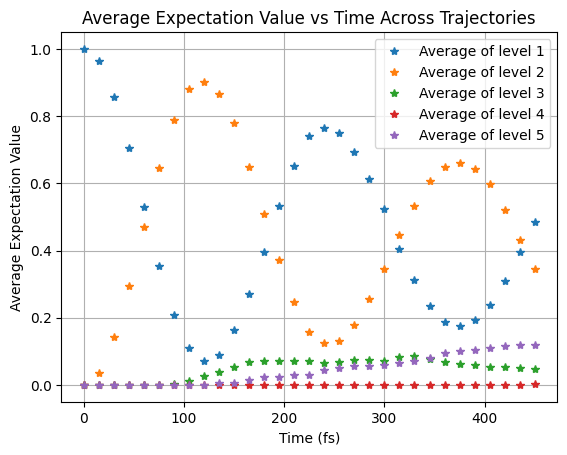

In [11]:
# Plot the average of all the observables
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], '*', label=f"Average of level {k+1}")

# Label the plot for the average
plt.xlabel('Time (fs)')
plt.ylabel('Average Expectation Value')
plt.title('Average Expectation Value vs Time Across Trajectories')
plt.legend()
plt.grid(True)
plt.show()

In [12]:

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

In [13]:
# Hamiltonian
H = Qobj([
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
])

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [Qobj(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [Qobj(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(Qobj(L_temp))

psi0_f = Qobj([[0], [1], [0], [0], [0]])
times = np.linspace(0.0, 450.0, 2000)
Mexp_f = [
    Qobj(np.diag([0, 1, 0, 0, 0])),
    Qobj(np.diag([0, 0, 1, 0, 0])),
    Qobj(np.diag([0, 0, 0, 1, 0])),
    Qobj(np.diag([1, 0, 0, 0, 0])),
    Qobj(np.diag([0, 0, 0, 0, 1]))
]
population = qutip_prop(H, psi0_f, times, Llist_f, Mexp_f)


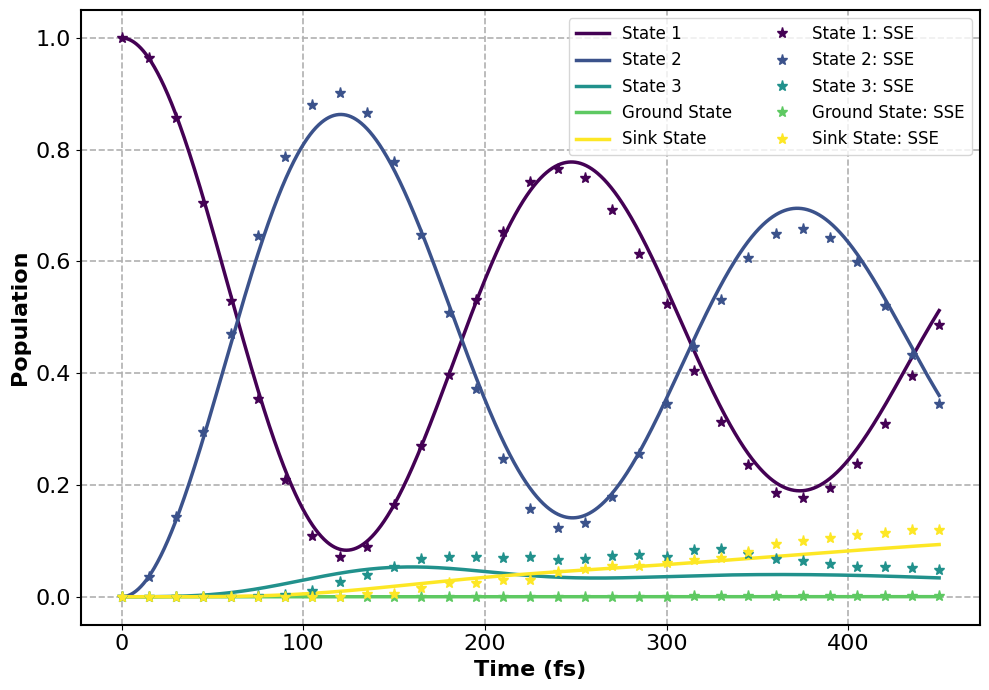

In [14]:
# Plotting the results
plt.figure(figsize=(10, 7))

# Line width and marker size
line_width = 2.5
marker_size = 8

# Define labels for the states
labels = ["State 1", "State 2", "State 3", "Ground State", "Sink State"]

# Define a colormap for consistent coloring
colors = plt.cm.viridis(np.linspace(0, 1, len(population)))

# Plot for population vs times
for i, (expec, label) in enumerate(zip(population, labels)):
    plt.plot(times, expec, label=label, color=colors[i], linewidth=line_width)

# Plot for average_expectation_values vs results_t_converted
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], 
             '*', color=colors[k], markersize=marker_size, label=f'{labels[k]}: SSE')

# Set labels, title, and grid
plt.xlabel('Time (fs)', fontsize=16, fontweight='bold')
plt.ylabel('Population', fontsize=16, fontweight='bold')
# plt.title('State Populations Over Time', fontsize=16, fontweight='bold')

# Create a combined legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks

# Set up the horizontal legend at the top right
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right', ncol=2, bbox_to_anchor=(1, 1))

# Make gridlines bolder
plt.grid(True, which='both', linestyle='--', linewidth=1.2)

# Increase the thickness of the plot borders
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig("state_populations_horizontal_legend.png", dpi=300)  # Save with high DPI for publication quality
plt.show()